In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import numpy as np
import pandas as pd

import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.dates as mdates
import matplotlib.cm as cm
plt.rcParams['figure.figsize'] = [10, 7]
plt.matplotlib.rcParams.update({'font.size': 18})

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import requests
import datetime
import copy
import math
import pickle

from tqdm.auto import tqdm
from datetime import timedelta, date
import time
import os
import numbers

import warnings
warnings.filterwarnings('ignore')

from jax import random
import numpyro
import numpyro.distributions as dist

from numpyro.infer import MCMC, NUTS, Predictive
import jax.random as random
import jax.numpy as jnp

import scenario_generator.curated as curated
import scenario_generator.mcmc_forecast as mcmc
import scenario_generator.utils as u

from mechafil.sim import run_simple_sim
from mechafil.data import get_historical_network_stats, get_sector_expiration_stats, \
    query_sector_expirations, get_cum_capped_qa_power, setup_spacescope
from mechafil.power import forecast_power_stats, build_full_power_stats_df
from mechafil.vesting import compute_vesting_trajectory_df
from mechafil.minting import compute_minting_trajectory_df, \
    network_time, cum_baseline_reward
from mechafil.supply import forecast_circulating_supply_df

from pycoingecko import CoinGeckoAPI
import datetime as dt

cg = CoinGeckoAPI()

from joblib import Parallel, delayed
import dill as pickle
from joblib import parallel_backend
from joblib import wrap_non_picklable_objects

"""
WARNING: You should be on the update_consensus_pledge_to_available_supply branch of 
mechaFIL for this code to work as intended!

This comment is relevant as of 2023-02-27
"""

'\nWARNING: You should be on the update_consensus_pledge_to_available_supply branch of \nmechaFIL for this code to work as intended!\n\nThis comment is relevant as of 2023-02-27\n'

In [3]:
# Overall Experiment Configuration

remove_baseline_from_pledge_qap_normalization = True
rbp_setting = 'last_historical'
rr_setting = 'last_historical'
fpr_setting = 0.6

# # pledge denominator experiment
# remove_baseline_from_pledge_qap_normalization = True
# rbp_setting = '10'
# rr_setting = 'last_historical'
# fpr_setting = 1

ss = 'no' if remove_baseline_from_pledge_qap_normalization else 'yes'
offline_folder = 'offline_info_rbp=%s_rr=%s_fpr=%s_pledgeincludesbaseline=%s' % (rbp_setting, rr_setting, fpr_setting, ss,)
results_folder = 'results_rbp=%s_rr=%s_fpr=%s_pledgeincludesbaseline=%s' % (rbp_setting, rr_setting, fpr_setting, ss,)
os.makedirs(offline_folder, exist_ok=True)
os.makedirs(results_folder, exist_ok=True)

In [4]:
NDEVICES = 2 
numpyro.set_host_device_count(NDEVICES)

# Data starts in filecoin_daily_stats 2021-03-15
# genesis block was in 2020-08-24
# Main net launch was in 2020-10-15

# set the simulation start date
#today = datetime.datetime.now().date() - timedelta(days=1)
today = datetime.date(2023, 2, 26)
DATA_LAG_DAYS = 0
current_date = today - timedelta(days=(DATA_LAG_DAYS))
current_day = (current_date - date(2020, 10, 15)).days

start_date = datetime.date(2021, 3, 16)
start_day = (start_date - datetime.date(2020, 10, 15)).days

# Forecast timeframe
forecast_lenght = int(365*8)
end_day = current_day + forecast_lenght
end_date = current_date + datetime.timedelta(days=forecast_lenght)

print(start_date)
print(current_date)
print(end_date)

auth_config='/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json'
setup_spacescope(auth_config)

2021-03-16
2023-02-26
2031-02-24


In [5]:
fpp = os.path.join(offline_folder, 'historical_inputs.pkl')
if os.path.exists(fpp):
    with open(fpp, 'rb') as f:
        z = pickle.load(f)
    t_rr = z['t_rr']
    historical_rr = z['rr']
    t_fpr = z['t_fpr']
    historical_fpr = z['fpr']
    t_rbp = z['t_rbp']
    historical_rbp = z['rbp']
else:
    t_rr, historical_rr = u.get_historical_renewal_rate(start_date, current_date)
    t_fpr, historical_fpr = u.get_historical_filplus_rate(start_date, current_date)
    t_rbp, historical_rbp = u.get_historical_daily_onboarded_power(start_date, current_date)

    save_dict = {
        't_rr': t_rr,
        'rr': historical_rr,
        't_fpr': t_fpr,
        'fpr': historical_fpr,
        't_rbp': t_rbp,
        'rbp': historical_rbp
    }
    with open(fpp, 'wb') as f:
        pickle.dump(save_dict, f)

In [6]:
fp = os.path.join(offline_folder, 'historical_network_stats.pkl')
if os.path.exists(fp):
    with open(fp, 'rb') as f:
        z = pickle.load(f)
    fil_stats_df = z['fil_stats_df']
    sector_expiration_stats_offline = z['sector_expiration_stats']
else:
    fil_stats_df = get_historical_network_stats(start_date,current_date,end_date)
    sector_expiration_stats_offline = get_sector_expiration_stats(start_date, current_date,end_date)
    
    dict_out = {
        'fil_stats_df': fil_stats_df,
        'sector_expiration_stats': sector_expiration_stats_offline
    }
    with open(fp, 'wb') as f:
        pickle.dump(dict_out, f)
        
# handy constants
EIB = 2 ** 60
PIB = 2 ** 50
TIB = 2 ** 40
GIB = 2 ** 30
SECTOR_SIZE = 32 * GIB
EPOCH_PER_DAY = 2880

MEGA = 1_000_000

In [7]:
def get_ts(id_='filecoin'):
    change_t = lambda x : datetime.datetime.utcfromtimestamp(x/1000).strftime('%Y-%m-%d')
    now = int(datetime.datetime.utcnow().timestamp())
    start_ago = int((datetime.datetime.utcnow() - dt.timedelta(700)).timestamp())
    ts = cg.get_coin_market_chart_range_by_id(id=id_,
                                              vs_currency='usd',
                                              from_timestamp=start_ago,to_timestamp=now
                                             )
    
    ts_df = pd.DataFrame({"coin" : id_,
                          "time_s" : np.array(ts['prices']).T[0],
                      "time_d" : list(map(change_t, np.array(ts['prices']).T[0])),
                      "price" : np.array(ts['prices']).T[1],
                      "market_caps" : np.array(ts['market_caps']).T[1], 
                      "total_volumes" : np.array(ts['total_volumes']).T[1]})
    
    return ts_df

# find baseline crossings
def find_crossings(df:pd.DataFrame)->pd.DataFrame:
    xing = np.array([])
    for i in range(df.iter[-1]+1):
        df_i = df[df['iter'] == i]
        df_crossing = df_i[df_i.network_RBP.values/EIB < baseline]
        if len(df_crossing) > 0:
            xing_i = df_i[df_i.network_RBP.values/EIB < baseline].index[0]
            xing = np.append(xing,xing_i)
    return xing

def baseline_storage(epoch:float)->float:
    # Spec value:
    # BASELINE_B0 = 2.88888888 
    # The following value is required to match sentinel
    # to Reproduce the first baseline crossing in backtest.
    # It's also close to the value the starboard use: 2.77. 
    # !Someone should look more closely at this.
    BASELINE_B0 = 2.7636 
    BASELINE_R = np.log(2) / (2880*365) # 1_051_200 in eopchs
    EPOCH_PER_DAY = 2880
    return BASELINE_B0 * np.exp(BASELINE_R * epoch)

def filter_df_date(df_in, min_date, max_date):
    df_out = df_in[(df_in['date']>= pd.to_datetime(min_date)) & (df_in['date']<=pd.to_datetime(max_date))]
    return df_out

def clip_all_powers(df_in):
    """
    'onboarded_power', 'cum_onboarded_power',
    'expire_scheduled_power', 'cum_expire_scheduled_power', 'renewed_power',
    'cum_renewed_power', 'total_power', 'power_type', 'total_qa_power_eib'
    """
    df_out = df_in.copy()
    for c in df_out.columns:
        if 'power' in c and c != 'power_type':
            df_out[c] = df_out[c].clip(lower=1e-6)
#             df_out[c] = df_out[c].clip(lower=0)
    return df_out

# add ROI to trajectory
def add_generated_quantities(cil_rbp, duration=365)->pd.DataFrame:
    # add ROI to trajectory df
    cil_rbp['day_pledge_per_QAP'] = SECTOR_SIZE * (cil_rbp['day_locked_pledge']-cil_rbp['day_renewed_pledge'])/(cil_rbp['day_onboarded_power_QAP'])
    cil_rbp['day_rewards_per_sector'] = SECTOR_SIZE * cil_rbp.day_network_reward / cil_rbp.network_QAP
    
    cil_rbp['1y_return_per_sector'] = cil_rbp['day_rewards_per_sector'].rolling(365).sum().shift(-365+1).values.flatten()
    cil_rbp['1y_sector_roi'] = cil_rbp['1y_return_per_sector'] / cil_rbp['day_pledge_per_QAP']

    cil_rbp['3y_return_per_sector'] = cil_rbp['day_rewards_per_sector'].rolling(365*3).sum().shift(-365*3+1).values.flatten()
    cil_rbp['3y_sector_roi'] = cil_rbp['3y_return_per_sector'] / cil_rbp['day_pledge_per_QAP']
    cil_rbp['3y_roi_annualized'] = np.power(cil_rbp['3y_sector_roi'] + 1, 1./3) - 1
    return cil_rbp

def add_USD_generated_quantities(df:pd.DataFrame, 
                                 price_df,
                                 costs=0, 
                                 future_price=3,
                                 duration_yr=1,
                                 ramp_len=60)->pd.DataFrame:
    
    COSTS = costs # FIL per sector
    final_real_price = price_df.price.values[-1]
    len_fil = df.shape[0] - price_df.shape[0]
    len_remain = len_fil - ramp_len
    df['usd'] = np.concatenate([price_df.price.values, 
                                np.linspace(final_real_price, future_price, ramp_len),
                                np.repeat(future_price, len_remain)])

    df['day_pledge_per_TIB_USD'] = df['day_pledge_per_QAP'] * df['usd'] / SECTOR_SIZE * TIB
    df['day_pledge_per_QAP_USD'] = df['day_pledge_per_QAP'] * df['usd']
    df['day_rewards_per_sector_USD'] = df['day_rewards_per_sector'] * df['usd']
    
    df['1y_return_per_sector_USD'] = df['day_rewards_per_sector_USD'].rolling(365).sum().shift(-365+1).values.flatten()
    df['1y_sector_roi_USD'] = (df['1y_return_per_sector_USD'] - COSTS) / df['day_pledge_per_QAP_USD']
    
    df['3y_return_per_sector_USD'] = df['day_rewards_per_sector_USD'].rolling(365*3).sum().shift(-365*3+1).values.flatten()
    df['3y_sector_roi_USD'] = (df['3y_return_per_sector_USD'] - COSTS) / df['day_pledge_per_QAP_USD']
    df['3y_sector_roi_USD_annualized'] = np.power(df['3y_sector_roi_USD'] + 1, 1./3) - 1
    
    return df

def run_sim(rb_onboard_power_pred_IN, renewal_rate_vec_pred_IN, fil_plus_rate_pred_IN,
            simulation_name='abc',
            duration=365, duration_m=None, qap_mode='basic', intervention_config={},
            sector_expiration_stats_IN=sector_expiration_stats_offline):
    # force spacescope setup since this is run in a separate process
    setup_spacescope(auth_config)
    
    # api for power-forecasting and circ-supply are slightly different
    renewal_rate_vec_IN = np.concatenate([historical_rr, renewal_rate_vec_pred_IN])    

    if sector_expiration_stats_IN is None:
        res = get_sector_expiration_stats(start_date, current_date,end_date)
    else:
        res = sector_expiration_stats_IN
    rb_known_scheduled_expire_vec = res[0]
    qa_known_scheduled_expire_vec = res[1]
    known_scheduled_pledge_release_full_vec = res[2]
    
    current_day_stats = fil_stats_df.iloc[-1]
    
    rb_power_zero = current_day_stats["total_raw_power_eib"] * 1024.0
    qa_power_zero = current_day_stats["total_qa_power_eib"] * 1024.0

    rb_power_df, qa_power_df = forecast_power_stats(
        rb_power_zero,
        qa_power_zero,
        rb_onboard_power_pred_IN,
        rb_known_scheduled_expire_vec,
        qa_known_scheduled_expire_vec,
        renewal_rate_vec_IN[-int(forecast_lenght):],
        fil_plus_rate_pred_IN,
        duration,
        forecast_lenght,
        duration_m=duration_m,
        qap_method=qap_mode,
        intervention_config=intervention_config,
        fpr_hist_info=(t_fpr, historical_fpr)
    )

    ########## BUG FIX
    rb_power_df = clip_all_powers(rb_power_df)
    qa_power_df = clip_all_powers(qa_power_df)
    ##########
    rb_power_df["total_raw_power_eib"] = rb_power_df["total_power"]/1024.0
    qa_power_df["total_qa_power_eib"] = qa_power_df["total_power"]/1024.0
        
    power_df = build_full_power_stats_df(
        fil_stats_df,
        rb_power_df,
        qa_power_df,
        start_date,
        current_date,
        end_date,
    )
    
    rb_total_power_eib = power_df["total_raw_power_eib"].values
    qa_total_power_eib = power_df["total_qa_power_eib"].values
    qa_day_onboarded_power_pib = power_df["day_onboarded_qa_power_pib"].values
    qa_day_renewed_power_pib = power_df["day_renewed_qa_power_pib"].values

    vest_df = compute_vesting_trajectory_df(start_date, end_date)
    
    mint_df_rbpbase = compute_minting_trajectory_df(
        start_date,
        end_date,
        rb_total_power_eib,
        qa_total_power_eib,
        qa_day_onboarded_power_pib,
        qa_day_renewed_power_pib,
        minting_base = 'rbp'
    )
    
    start_day_stats = fil_stats_df.iloc[0]
    circ_supply_zero = start_day_stats["circulating_fil"]
    locked_fil_zero = start_day_stats["locked_fil"]
    burnt_fil_zero = start_day_stats["burnt_fil"]
    daily_burnt_fil = intervention_config['burn_boost_value'] * fil_stats_df["burnt_fil"].diff().mean()
    burnt_fil_vec = fil_stats_df["burnt_fil"].values

    cil_df_rbp = forecast_circulating_supply_df(
        start_date,
        current_date,
        end_date,
        circ_supply_zero,
        locked_fil_zero,
        daily_burnt_fil,
        duration,
        renewal_rate_vec_IN,
        burnt_fil_vec,
        vest_df,
        mint_df_rbpbase,
        known_scheduled_pledge_release_full_vec,
        lock_target=0.3,  # the historical baseline lock target
        fil_plus_rate=fil_plus_rate_pred_IN,
        intervention_config=intervention_config,
        fpr_hist_info=(t_fpr, historical_fpr)
    )
    
    rbp_roi = add_generated_quantities(cil_df_rbp, duration=duration)
    
    return_dict = {
        'power_df': power_df,
        'rb_power_df': rb_power_df,
        'qa_power_df': qa_power_df,
        'mint_df': mint_df_rbpbase,
        'rbp_roi': rbp_roi,
        'renewal_rate_vec': renewal_rate_vec_IN,
        'rb_onboard_power_pred': rb_onboard_power_pred_IN,
        'fil_plus_rate_pred': fil_plus_rate_pred_IN,
        'sim_name': simulation_name
    }
    
    return return_dict

def generate_mcmc_forecast_samples(train_start_date: datetime.date,
                                   train_end_date: datetime.date,
                                   forecast_length: int,
                                   num_warmup_mcmc: int = 500,
                                   num_samples_mcmc: int = 100,
                                   seasonality_mcmc: int = 1000,
                                   num_chains_mcmc: int = 2):
    print("Forecasting Onboarding Power")
    forecast_rb_date_vec, rb_onboard_power_pred, _, _ = \
        mcmc.forecast_rb_onboard_power(train_start_date, 
                                       train_end_date,
                                       forecast_length,
                                       num_warmup_mcmc = num_warmup_mcmc,
                                       num_samples_mcmc = num_samples_mcmc,
                                       seasonality_mcmc = seasonality_mcmc,
                                       num_chains_mcmc = num_chains_mcmc)
    print("Forecasting Renewal Rate")
    forecast_rr_date_vec, renewal_rate_pred, _ , _ = \
        mcmc.forecast_renewal_rate(train_start_date, 
                                   train_end_date,
                                   forecast_length,
                                   num_warmup_mcmc = num_warmup_mcmc,
                                   num_samples_mcmc = num_samples_mcmc,
                                   seasonality_mcmc = seasonality_mcmc,
                                   num_chains_mcmc = num_chains_mcmc)
    
    print("Forecasting FIL+ Rate")
    forecast_fpr_date_vec, filplus_rate_pred, _, _ = \
        mcmc.forecast_filplus_rate(train_start_date, 
                                   train_end_date,
                                   forecast_length,
                                   num_warmup_mcmc = num_warmup_mcmc,
                                   num_samples_mcmc = num_samples_mcmc,
                                   seasonality_mcmc = seasonality_mcmc,
                                   num_chains_mcmc = num_chains_mcmc)
    assert np.array_equal(forecast_rb_date_vec, forecast_rr_date_vec)
    assert np.array_equal(forecast_rr_date_vec, forecast_fpr_date_vec)
    return rb_onboard_power_pred, renewal_rate_pred, filplus_rate_pred

In [8]:
current_day_stats = fil_stats_df.iloc[-1]
rb_power_zero = current_day_stats["total_raw_power_eib"] * 1024.0

In [9]:
def duration_master_fn(d, slope=1, clip=None):
    if d < round(365*1.5):
        return 1
    else:
        y1_slp1 = 1
        y2_slp1 = 2 - 183/365.
        x1_slp1 = round(365*1.5)
        x2_slp1 = 365*2
        m = (y2_slp1 - y1_slp1) / (x2_slp1 - x1_slp1)
        m *= slope
        # y-y1 = m*(x-x1)
        y = m*(d - x1_slp1) + y1_slp1
        if clip is not None:
            if y > clip:
                y = clip
        return y
    
# define duration multiplier callables - we need to redefine these callables to be compatible w/ mechaFIL
def no_sdm(d):
    return 1

def duration_m_slp_1_noclip(d):
    return duration_master_fn(d, slope=1, clip=None)

def duration_m_slp_0_1_noclip(d):
    return duration_master_fn(d, slope=0.1, clip=None)

def duration_m_slp_0_285_noclip(d):
    return duration_master_fn(d, slope=0.285, clip=None)

def duration_m_slp_0_5_noclip(d):
    return duration_master_fn(d, slope=0.5, clip=None)


slp2callable = {
    '%0.02f' % (1,): duration_m_slp_1_noclip,
    '%0.02f' % (0.1,): duration_m_slp_0_1_noclip,
    '%0.02f' % (0.285,): duration_m_slp_0_285_noclip,
    '%0.02f' % (0.5,): duration_m_slp_0_5_noclip,
}

In [10]:
intervention_date=today+timedelta(days=1)
duration_m = lambda d: (1 if d <= round(365*1.5) else (d-183)/365)
no_sdm = lambda d: 1
num_days_shock_behavior = 360
days_to_target=1

qap_mode = 'basic-sdm'

current_rbp = historical_rbp[-1]
current_rr = historical_rr[-1]

print(current_rbp, current_rr)

sim_vec=[]

# in order to better interpret results, scanning isn't
# done but rather fixed values. Lists are left in here
# in case we want to change to scans
rbp_scan_vec=[rbp_setting]
rr_scan_vec=[rr_setting]
filplus_scan_vec = [fpr_setting]

durations_vec_yrs=[1,5]
lock_targets=[0.3, 0.5]
burn_boosts=[1]
regimes = ['data_conserved', 'fil_conserved']
behaviors_vec = ['smooth']
duration_slopes_vec = [0.285]
pledge_base_config_vec = [
    ('circulating_supply', 'circulating_supply'), 
    ('circulating_supply', 'available_supply') 
]

for burn_boost in burn_boosts:
    for lock_target in lock_targets:
        for regime in regimes:
            for behavior in behaviors_vec:
                if behavior == 'smooth':
                    intervention_type='noop'
                elif behavior == 'jump':
                    intervention_type='cc_early_renewal'
                    
                for pledge_base_config in pledge_base_config_vec:
                    pledge_base_config_str = pledge_base_config[0] + '-' + pledge_base_config[1]
                
                    for duration_yr in durations_vec_yrs:
                        duration_days = duration_yr * 365

                        for rbp_i in rbp_scan_vec:
                            for rr_i in rr_scan_vec:
                                for filplus_i in filplus_scan_vec:
                                    if rbp_i == 'mcmc':
                                        rb_onboard_i_power_forecast = copy.deepcopy(mcmc_scenario['rb_onboard_power'][0:forecast_lenght])
                                    elif rbp_i == 'last_historical':
                                        rb_onboard_i_power_forecast = np.ones(forecast_lenght)*current_rbp
                                    else:
                                        rb_onboard_i_power_forecast = np.ones(forecast_lenght)*float(rbp_i)

                                    if rr_i == 'mcmc':
                                        rr_i_forecast = copy.deepcopy(mcmc_scenario['renewal_rate'][0:forecast_lenght])
                                    elif rr_i == 'last_historical':
                                        rr_i_forecast = np.ones(forecast_lenght)*current_rr
                                    else:
                                        rr_i_forecast = np.ones(forecast_length)*float(rr_i)

                                    if filplus_i == 'mcmc':
                                        fpr_i_forecast = copy.deepcopy(mcmc_scenario['filplus_rate'][0:forecast_lenght])
                                    else:
                                        fpr_i_forecast = np.ones(forecast_lenght)*filplus_i
                                        
                                    for duration_slope in duration_slopes_vec:
                                        duration_m_in = slp2callable['%0.02f' % (duration_slope)]
                                        if regime == 'data_conserved':
                                            qap_scale_factor = 1.
                                        elif regime == 'fil_conserved':
                                            qap_scale_factor = duration_m_in(duration_days)
                                        else:
                                            raise ValueError("Unsupported conservation regime!")
                                        qap_scale_factor = float(qap_scale_factor)

                                        rb_onboard_i_power_forecast_scaled = rb_onboard_i_power_forecast[0:forecast_lenght]/qap_scale_factor
                                        rr_i_forecast_scaled = rr_i_forecast[0:forecast_lenght]/qap_scale_factor

                                        key_store = 'bb=%d-lt=%0.02f-regime=%s-duration=%0.02f-behavior=%s-pledgebase=%s-rbp=%s-rr=%s-fpr=%s-sdmslope=%0.02f' % \
                                            (burn_boost, lock_target, regime, duration_yr, behavior, pledge_base_config_str, str(rbp_i), str(rr_i), str(filplus_i), duration_slope)
                                        sdm_cfg = {
                                            'name': 'SDM-(%s)' % (key_store,), 
                                            'rbp': copy.deepcopy(rb_onboard_i_power_forecast_scaled),
                                            'rr': copy.deepcopy(rr_i_forecast_scaled),
                                            'fpr': copy.deepcopy(fpr_i_forecast),
                                            'kwargs':{
                                                'duration': duration_days, 
                                                'duration_m': duration_m_in, 
                                                'qap_mode': qap_mode,      
                                                'intervention_config': {
                                                    'type': intervention_type,
                                                    'num_days_shock_behavior': num_days_shock_behavior,
                                                    'intervention_date': intervention_date,
                                                    'simulation_start_date': current_date + datetime.timedelta(days=1),
                                                    'sdm_onboard_before_intervention': False,
                                                    'sdm_onboard_after_intervention': True,
                                                    'sdm_renew_before_intervention': False,
                                                    'sdm_renew_after_intervention': True,
                                                    'lock_target_update_date': intervention_date,
                                                    'lock_target_update_value': lock_target,
                                                    'burn_boost_value': burn_boost,
                                                    'consensus_pledge_method_before_intervention': pledge_base_config[0],
                                                    'consensus_pledge_method_after_intervention': pledge_base_config[1],
                                                    'remove_baseline_from_pledge_qap_normalization': False
                                                }
                                            }
                                        }
                                        sim_vec.append(copy.deepcopy(sdm_cfg))


5.836090087890625 0.6979754616811035


In [11]:
fp_sims = os.path.join(offline_folder, 'duration_loop_results_without_pledge_rescale.pkl')
if os.path.exists(fp_sims):
    with open(fp_sims, 'rb') as f:
        duration_loop_results_without_pledge_rescale = pickle.load(f)
else:
    n_jobs = 4
    idxs = range(len(sim_vec))
    results = Parallel(n_jobs=n_jobs)(delayed(run_sim)(
        sim_vec[i]['rbp'], sim_vec[i]['rr'], sim_vec[i]['fpr'], simulation_name=sim_vec[i]['name'], **sim_vec[i]['kwargs']
    ) for i in tqdm(idxs))

    # # serial version
    # results = []
    # for i in tqdm(idxs):
    #     r = run_sim(sim_vec[i]['rbp'], sim_vec[i]['rr'], sim_vec[i]['fpr'], simulation_name=sim_vec[i]['name'], **sim_vec[i]['kwargs'])
    #     results.append(r)

    duration_loop_results_without_pledge_rescale = {}
    for res in results:
        duration_loop_results_without_pledge_rescale[res['sim_name']] = res
        
    with open(fp_sims, 'wb') as f:
        pickle.dump(duration_loop_results_without_pledge_rescale, f)    

  0%|          | 0/16 [00:00<?, ?it/s]

/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these wil

/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these wil

In [12]:
# now rescale the rbp to conserve according to lock-target also
sim_vec_with_pledge_rescale = []

for burn_boost in burn_boosts:
    for lock_target in lock_targets:
        for regime in regimes:
            for behavior in behaviors_vec:
                if behavior == 'smooth':
                    intervention_type='noop'
                elif behavior == 'jump':
                    intervention_type='cc_early_renewal'
                    
                for duration_yr in durations_vec_yrs:
                    duration_days = duration_yr * 365
                    for rbp_i in rbp_scan_vec:
                        for rr_i in rr_scan_vec:
                            for filplus_i in filplus_scan_vec:
                                for duration_slope in duration_slopes_vec:
                                    duration_m_in = slp2callable['%0.02f' % (duration_slope)]
                                    
                                    pbc1 = 'circulating_supply-circulating_supply'
                                    k1 = 'bb=%d-lt=%0.02f-regime=%s-duration=%0.02f-behavior=%s-pledgebase=%s-rbp=%s-rr=%s-fpr=%s-sdmslope=%0.02f' % \
                                          (burn_boost, lock_target, regime, duration_yr, behavior, pbc1, str(rbp_i), str(rr_i), str(filplus_i), duration_slope)
                                    pbc2 = 'circulating_supply-available_supply'
                                    k2 = 'bb=%d-lt=%0.02f-regime=%s-duration=%0.02f-behavior=%s-pledgebase=%s-rbp=%s-rr=%s-fpr=%s-sdmslope=%0.02f' % \
                                          (burn_boost, lock_target, regime, duration_yr, behavior, pbc2, str(rbp_i), str(rr_i), str(filplus_i), duration_slope)
                                    
                                    exp_cscs = 'SDM-(%s)' % (k1,)
                                    exp_csas = 'SDM-(%s)' % (k2,)
                                    
                                    pledge_cscs = duration_loop_results_without_pledge_rescale[exp_cscs]['rbp_roi']['day_pledge_per_QAP']
                                    pledge_csas = duration_loop_results_without_pledge_rescale[exp_csas]['rbp_roi']['day_pledge_per_QAP']
                                    pledge_delta = pledge_csas/pledge_cscs
                                    # get it for the intervention date
                                    df =  duration_loop_results_without_pledge_rescale[exp_cscs]['rbp_roi']
                                    ii = df[df['date'] == (intervention_date)].index[0]
                                    pledge_scaler = pledge_delta.iloc[ii:].values # first value is 0 due to sim dynamics
                                    
                                    if regime == 'fil_conserved':
                                        print(lock_target, duration_yr, duration_slope, '%0.02f' % (np.mean(pledge_scaler),), '%0.02f' % (pledge_scaler[1],))
                                    
                                    rbp_in = copy.deepcopy(duration_loop_results_without_pledge_rescale[exp_cscs]['rb_onboard_power_pred'])
                                    rr_in = copy.deepcopy(duration_loop_results_without_pledge_rescale[exp_cscs]['renewal_rate_vec'][len(historical_rr):])
                                    fpr_in = copy.deepcopy(duration_loop_results_without_pledge_rescale[exp_cscs]['fil_plus_rate_pred'])
                                    
                                    qap_scale_factor = np.mean(pledge_scaler)
                                    rbp_in_scaled = copy.deepcopy(rbp_in) / qap_scale_factor
                                    rr_in_scaled = copy.deepcopy(rr_in) / qap_scale_factor
                                    
                                    # create new inputs for the appropriate configs
                                    sdm_cfg = {
                                        'name': '%s' % (exp_cscs,), 
                                        'rbp': copy.deepcopy(rbp_in),
                                        'rr': copy.deepcopy(rr_in),
                                        'fpr': copy.deepcopy(fpr_in),
                                        'kwargs':{
                                            'duration': duration_days, 
                                            'duration_m': duration_m_in, 
                                            'qap_mode': qap_mode,      
                                            'intervention_config': {
                                                'type': intervention_type,
                                                'num_days_shock_behavior': num_days_shock_behavior,
                                                'intervention_date': intervention_date,
                                                'simulation_start_date': current_date + datetime.timedelta(days=1),
                                                'sdm_onboard_before_intervention': False,
                                                'sdm_onboard_after_intervention': True,
                                                'sdm_renew_before_intervention': False,
                                                'sdm_renew_after_intervention': True,
                                                'lock_target_update_date': intervention_date,
                                                'lock_target_update_value': lock_target,
                                                'burn_boost_value': burn_boost,
                                                'consensus_pledge_method_before_intervention': 'circulating_supply',
                                                'consensus_pledge_method_after_intervention': 'circulating_supply',
                                                'remove_baseline_from_pledge_qap_normalization': False   
                                            }
                                        }
                                    }
                                    sim_vec_with_pledge_rescale.append(copy.deepcopy(sdm_cfg))
                                    
                                    # create new inputs for the appropriate configs
                                    sdm_cfg = {
                                        'name': '%s' % (exp_csas,), 
                                        'rbp': copy.deepcopy(rbp_in_scaled) if regime == 'fil_conserved' else copy.deepcopy(rbp_in),
                                        'rr': copy.deepcopy(rr_in_scaled) if regime == 'fil_conserved' else copy.deepcopy(rr_in),
                                        'fpr': copy.deepcopy(fpr_in),
                                        'kwargs':{
                                            'duration': duration_days, 
                                            'duration_m': duration_m_in, 
                                            'qap_mode': qap_mode,      
                                            'intervention_config': {
                                                'type': intervention_type,
                                                'num_days_shock_behavior': num_days_shock_behavior,
                                                'intervention_date': intervention_date,
                                                'simulation_start_date': current_date + datetime.timedelta(days=1),
                                                'sdm_onboard_before_intervention': False,
                                                'sdm_onboard_after_intervention': True,
                                                'sdm_renew_before_intervention': False,
                                                'sdm_renew_after_intervention': True,
                                                'lock_target_update_date': intervention_date,
                                                'lock_target_update_value': lock_target,
                                                'burn_boost_value': burn_boost,
                                                'consensus_pledge_method_before_intervention': 'circulating_supply',
                                                'consensus_pledge_method_after_intervention': 'available_supply',
                                                'remove_baseline_from_pledge_qap_normalization': remove_baseline_from_pledge_qap_normalization
                                            }
                                        }
                                    }
                                    sim_vec_with_pledge_rescale.append(copy.deepcopy(sdm_cfg))
                                    
                                    
#                                     print('>'*10)
#                                     print(lock_target, regime, duration_days, duration_slope)
#                                     print(np.mean(pledge_scaler), pledge_scaler[1])
#                                     print(len(pledge_scaler), len(duration_loop_results_without_pledge_rescale[exp_cscs]['rb_onboard_power_pred']))
#                                     print('<'*10)

                                    

0.3 1 0.285 1.19 1.34
0.3 5 0.285 1.31 1.34
0.5 1 0.285 1.28 1.35
0.5 5 0.285 1.53 1.35


In [13]:
# rerun simulations
fp_sims = os.path.join(offline_folder, 'duration_loop_results_with_pledge_rescale.pkl')
if os.path.exists(fp_sims):
    with open(fp_sims, 'rb') as f:
        duration_loop_results_with_pledge_rescale = pickle.load(f)
else:
    n_jobs = 4
    idxs = range(len(sim_vec_with_pledge_rescale))
    results = Parallel(n_jobs=n_jobs)(delayed(run_sim)(
        sim_vec_with_pledge_rescale[i]['rbp'], 
        sim_vec_with_pledge_rescale[i]['rr'], 
        sim_vec_with_pledge_rescale[i]['fpr'], 
        simulation_name=sim_vec_with_pledge_rescale[i]['name'], 
        **sim_vec_with_pledge_rescale[i]['kwargs']
    ) for i in tqdm(idxs))

    # convert the list into a dictionary to keep API
    duration_loop_results_with_pledge_rescale = {}
    for res in results:
        duration_loop_results_with_pledge_rescale[res['sim_name']] = res
        
    with open(fp_sims, 'wb') as f:
        pickle.dump(duration_loop_results_with_pledge_rescale, f)

  0%|          | 0/16 [00:00<?, ?it/s]

/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these wil

/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these wil

In [14]:
plt.rcParams.update({'font.size': 10}) # default
def get_paired_quantity(df1, df2, key, scale_by=1):
    return df1[key]*scale_by, df2[key]*scale_by
    
start_plot_date = current_date - timedelta(days=180)
end_plot_date = date(2030,1,1)
cmap_access_vec = np.linspace(0.35,0.75,2)  # for modulating between the cs/cs and cs/as scenarios

def plt_power(df_summaries_by_dur,
              cfgs_to_plot,
              plot_kwargs_list,
              sup_title_str='',
              save_fp=None):

    nx = 3
    ny = 2
    fig, axs = plt.subplots(nx, ny, constrained_layout=True, figsize=(9,9))
    rolling_fn = lambda x: np.nanmedian(x)
    
    for ii, exp_configs in enumerate(cfgs_to_plot):
        plt_kwargs = plot_kwargs_list[ii]
        kw_in = copy.copy(plt_kwargs)
        cmap = kw_in.pop('color')
        lbl = kw_in.pop('label')
        
        exp_cscs = exp_configs[0]
        exp_csas = exp_configs[1]
        df_cscs = df_summaries_by_dur[exp_cscs]['rbp_roi']
        df_csas = df_summaries_by_dur[exp_csas]['rbp_roi']
        
        # filter timeline
        df_cscs = df_cscs[(df_cscs['date'] >= pd.to_datetime(start_plot_date)) & (df_cscs['date'] <= pd.to_datetime(end_plot_date))]
        df_csas = df_csas[(df_csas['date'] >= pd.to_datetime(start_plot_date)) & (df_csas['date'] <= pd.to_datetime(end_plot_date))]
        dates_ = df_cscs['date']
        
        qap_cscs, qap_csas = get_paired_quantity(df_cscs, df_csas, 'network_QAP', 1./EIB)
        axs[0,0].plot(dates_, qap_cscs, color=cmap(0.75), label=lbl+' CS-CS', **kw_in)
        axs[0,0].plot(dates_, qap_csas, color=cmap(0.35), label=lbl+' CS-AS', **kw_in)
        axs[0,0].axvline(intervention_date, linestyle=':', color='k', linewidth=0.5)
        axs[0,0].set_title('Network QAP')
        axs[0,0].set_ylabel('EiB')
        axs[0,0].set_ylim(0,100)
        if ii == 0:
            axs[0,0].plot(dates_, df_cscs['network_baseline']/EIB, color='k', linewidth=0.7, linestyle=':', label='Baseline')
        axs[0,0].legend(fontsize=6,ncol=2)
        
        rbp_cscs, rbp_csas = get_paired_quantity(df_cscs, df_csas, 'network_RBP', 1./EIB)
        axs[0,1].plot(dates_, rbp_cscs, color=cmap(0.75), label=lbl+' CS-CS', **kw_in)
        axs[0,1].plot(dates_, rbp_csas, color=cmap(0.35), label=lbl+' CS-AS', **kw_in)
        axs[0,1].axvline(intervention_date, linestyle=':', color='k', linewidth=0.5)
        axs[0,1].set_title('Network RBP')
        axs[0,1].set_ylabel('EiB')
        
        minting_cscs, minting_csas = get_paired_quantity(df_cscs, df_csas, 'day_network_reward', 1)
        axs[1,0].plot(dates_, minting_cscs.rolling(7).apply(rolling_fn), color=cmap(0.75), label=lbl+' CS', **kw_in)
        axs[1,0].plot(dates_, minting_csas.rolling(7).apply(rolling_fn), color=cmap(0.35), label=lbl+' AS', **kw_in)
        axs[1,0].set_title('Minting')
        axs[1,0].set_ylabel('FIL/day')
        axs[1,0].axvline(intervention_date, linestyle=':', color='k', linewidth=0.5)
        
        roi_cscs, roi_csas = get_paired_quantity(df_cscs, df_csas, '1y_sector_roi', 1.)
        axs[1,1].plot(dates_, roi_csas/roi_cscs, label=lbl, color=cmap(0.55), **kw_in)
        axs[1,1].set_title('1Y Sector ROI CS-AS/CS-CS')
        axs[1,1].set_ylabel('Ratio')
        axs[1,1].axvline(intervention_date, linestyle=':', color='k', linewidth=0.5)
#         axs[1,1].set_ylim(5,80)
        
        pledge_cscs, pledge_csas = get_paired_quantity(df_cscs, df_csas, 'day_pledge_per_QAP', 1.)
        axs[2,0].plot(dates_, (pledge_csas/pledge_cscs).rolling(7).apply(rolling_fn), label=lbl + " AS/CS", color=cmap(0.55), **kw_in)
        axs[2,0].set_title('Pledge/32GiB Ratio')
        axs[2,0].axvline(intervention_date, linestyle=':', color='k', linewidth=0.5)
        axs[2,0].set_ylabel('Ratio')
        axs[2,0].legend(fontsize=7, ncol=2)
        
        axs[2,1].plot(dates_, pledge_cscs.rolling(7).apply(rolling_fn), color=cmap(0.75), label=lbl+' CS', **kw_in)
        axs[2,1].plot(dates_, pledge_csas.rolling(7).apply(rolling_fn), color=cmap(0.35), label=lbl+' AS', **kw_in)
        axs[2,1].set_title('Pledge/32GiB')
        axs[2,1].axvline(intervention_date, linestyle=':', color='k', linewidth=0.5)
        axs[2,1].set_ylabel('FIL')
        axs[2,1].legend(fontsize=7, ncol=2)
        
        
    if sup_title_str is not None and sup_title_str != '':
        plt.suptitle(sup_title_str, fontsize=12)
    for ii in range(nx):
        for jj in range(ny):
            axs[ii,jj].tick_params(axis='x', labelrotation = 60)
    
    plt.tight_layout()
    
    if save_fp is not None:
        plt.savefig(save_fp)
        
def plt_supply(df_summaries_by_dur,
               cfgs_to_plot,
               plot_kwargs_list,
               sup_title_str='',
               save_fp=None):

    nx = 3
    ny = 2
    fig, axs = plt.subplots(nx, ny, constrained_layout=True, figsize=(9,9))
    rolling_fn = lambda x: np.nanmedian(x)
    
    for ii, exp_configs in enumerate(cfgs_to_plot):
        plt_kwargs = plot_kwargs_list[ii]
        kw_in = copy.copy(plt_kwargs)
        cmap = kw_in.pop('color')
        lbl = kw_in.pop('label')
        
        exp_cscs = exp_configs[0]
        exp_csas = exp_configs[1]
        df_cscs = df_summaries_by_dur[exp_cscs]['rbp_roi']
        df_csas = df_summaries_by_dur[exp_csas]['rbp_roi']
        
        # filter timeline
        df_cscs = df_cscs[(df_cscs['date'] >= pd.to_datetime(start_plot_date)) & (df_cscs['date'] <= pd.to_datetime(end_plot_date))]
        df_csas = df_csas[(df_csas['date'] >= pd.to_datetime(start_plot_date)) & (df_csas['date'] <= pd.to_datetime(end_plot_date))]
        dates_ = df_cscs['date']

        cs_cscs, cs_csas = get_paired_quantity(df_cscs, df_csas, 'circ_supply', 1./1e6)
        locked_cscs, locked_csas = get_paired_quantity(df_cscs, df_csas, 'network_locked', 1./1e6)
        as_cscs = cs_cscs + locked_cscs
        as_csas = cs_csas + locked_csas
        
        axs[0,0].plot(dates_, cs_csas/cs_cscs, label=lbl + " AS/CS", color=cmap(0.55), **kw_in)
        axs[0,0].set_title('Circulating Supply Ratio')
        axs[0,0].axvline(intervention_date, linestyle=':', color='k', linewidth=0.5)
        axs[0,0].set_ylabel('Ratio')
#         axs[0,0].legend(fontsize=7)
        
#         axs[0,1].plot(dates_, as_cscs, color=cmap(0.75), label=lbl+'CS-CS', **kw_in)
#         axs[0,1].plot(dates_, as_csas, color=cmap(0.35), label=lbl+'CS-AS', **kw_in)
#         axs[0,1].set_title('Available Supply')
#         axs[0,1].axvline(intervention_date, linestyle=':', color='k', linewidth=0.5)
#         axs[0,1].set_ylabel('M-FIL')
        axs[0,1].plot(dates_, cs_cscs, color=cmap(0.75), label=lbl+' CS', **kw_in)
        axs[0,1].plot(dates_, cs_csas, color=cmap(0.35), label=lbl+' AS', **kw_in)
        axs[0,1].set_title('Circulating Supply')
        axs[0,1].axvline(intervention_date, linestyle=':', color='k', linewidth=0.5)
        axs[0,1].set_ylabel('M-FIL')

        axs[1,0].plot(dates_, (locked_csas/locked_cscs).apply(rolling_fn), label=lbl + " AS/CS", color=cmap(0.55), **kw_in)
        axs[1,0].axvline(intervention_date, linestyle=':', color='k', linewidth=0.5)
        axs[1,0].set_title('Network Locked Ratio')
        axs[1,0].set_ylabel('Ratio')
        axs[1,0].legend(fontsize=7)

        df_cscs['cum_netflow'] = -1*(df_cscs['network_gas_burn'] + df_cscs['network_locked']) + (df_cscs['total_vest'] + df_cscs['cum_network_reward'])
        df_csas['cum_netflow'] = -1*(df_csas['network_gas_burn'] + df_csas['network_locked']) + (df_csas['total_vest'] + df_csas['cum_network_reward'])
        cscs_netflow = df_cscs['cum_netflow'].diff() / 1e6
        csas_netflow = df_csas['cum_netflow'].diff() / 1e6
        axs[1,1].plot(dates_, cscs_netflow.rolling(7).apply(rolling_fn), color=cmap(0.75), label=lbl+' CS', **kw_in)
        axs[1,1].plot(dates_, csas_netflow.rolling(7).apply(rolling_fn), color=cmap(0.35), label=lbl+' AS', **kw_in)
        axs[1,1].axvline(intervention_date, linestyle=':', color='k', linewidth=0.5)
        axs[1,1].set_title('Net Flow')
        axs[1,1].set_ylabel('M-FIL')
        axs[1,1].set_ylim(-1,1)
        axs[1,1].legend(fontsize=7, ncol=2)
        
        l_div_cs_cscs = (locked_cscs / cs_cscs) * 100
        l_div_cs_csas = (locked_csas / cs_csas) * 100
        axs[2,0].plot(dates_, l_div_cs_cscs, color=cmap(0.75), label=lbl+' CS', **kw_in)
        axs[2,0].plot(dates_, l_div_cs_csas, color=cmap(0.35), label=lbl+' AS', **kw_in)
        axs[2,0].set_title('Locked/Circ-Supply')
        axs[2,0].axvline(intervention_date, linestyle=':', color='k', linewidth=0.5)
        axs[2,0].set_ylabel('%')
        axs[2,0].set_yscale('log')
        
        l_div_as_cscs = (locked_cscs / as_cscs) * 100
        l_div_as_csas = (locked_csas / as_csas) * 100
        axs[2,1].plot(dates_, l_div_as_cscs, color=cmap(0.75), label=lbl+' CS', **kw_in)
        axs[2,1].plot(dates_, l_div_as_csas, color=cmap(0.35), label=lbl+' AS', **kw_in)
        axs[2,1].set_title('Locked/Available-Supply')
        axs[2,1].axvline(intervention_date, linestyle=':', color='k', linewidth=0.5)
        axs[2,1].set_ylabel('%')
        
    
    if sup_title_str is not None and sup_title_str != '':
        plt.suptitle(sup_title_str, fontsize=12)
    for ii in range(nx):
        for jj in range(ny):
            axs[ii,jj].tick_params(axis='x', labelrotation = 60)
    
    plt.tight_layout()
    
    if save_fp is not None:
        plt.savefig(save_fp)

In [19]:
plt_durations_vec_yrs=[1,5]
plt_durations_vec_yrs_str = '-'.join(['%dY' % (x,) for x in plt_durations_vec_yrs])
plt_lock_targets=[0.3, 0.5]

plt_burn_boosts=[1]
plt_rbp_scan_vec=[rbp_setting]
plt_rr_scan_vec=[rr_setting]
plt_filplus_scan_vec = [fpr_setting]
plt_duration_slopes_vec = [0.285]
plt_pledge_base_config_vec = [
    ('circulating_supply', 'circulating_supply'), 
    ('circulating_supply', 'available_supply') 
]

colormap_vecs = ['Purples', 'Greens', 'Oranges', 'Blues', 'Reds']
# colormap_vecs = ['Greens', 'Oranges', 'Blues', 'Reds']
cmap_access_vec = np.linspace(0.35,0.75,len(plt_pledge_base_config_vec))
# cmap_access_vec = [0.55]
linestyles=['-', '--', ':']

In [26]:
# incentives to terminate plot
plt_regime = 'fil_conserved'
plt_configs = []
plt_kwargs_list = []
for aa, burn_boost in enumerate(plt_burn_boosts):
    for bb, lock_target in enumerate(plt_lock_targets):
        for dd, duration_yr in enumerate(plt_durations_vec_yrs):
            for ee, rbp_i in enumerate(plt_rbp_scan_vec):
                for ff, rr_i in enumerate(plt_rr_scan_vec):
                    for gg, filplus_i in enumerate(plt_filplus_scan_vec):
                        for hh, duration_slope in enumerate(plt_duration_slopes_vec):
                            pledge_base_config_str_config = 'circulating_supply-circulating_supply'
                            cscs_key = 'bb=%d-lt=%0.02f-regime=%s-duration=%0.02f-behavior=%s-pledgebase=%s-rbp=%s-rr=%s-fpr=%s-sdmslope=%0.02f' % \
                                        (burn_boost, lock_target, plt_regime, duration_yr, behavior, pledge_base_config_str_config, str(rbp_i), str(rr_i), str(filplus_i), duration_slope)
                            cscs_key = 'SDM-(%s)' % (cscs_key,)

                            pledge_base_config_str_config = 'circulating_supply-available_supply'
                            csas_key = 'bb=%d-lt=%0.02f-regime=%s-duration=%0.02f-behavior=%s-pledgebase=%s-rbp=%s-rr=%s-fpr=%s-sdmslope=%0.02f' % \
                                        (burn_boost, lock_target, plt_regime, duration_yr, behavior, pledge_base_config_str_config, str(rbp_i), str(rr_i), str(filplus_i), duration_slope)
                            csas_key = 'SDM-(%s)' % (csas_key,)

                            plt_configs.append((cscs_key, csas_key))
                            #cmap = cm.get_cmap(colormap_vecs[dd])
                            cmap = cm.get_cmap(colormap_vecs[(bb*len(plt_lock_targets)+dd) % (len(colormap_vecs))])
#                             ls = linestyles[pbc % len(linestyles)]
                            plt_kwargs_list.append({
                                'label':'%dY-LT=%0.02f' % (duration_yr,lock_target),
                                'color':cmap,
#                                     'linestyle': ls
                            })

<IPython.core.display.Javascript object>


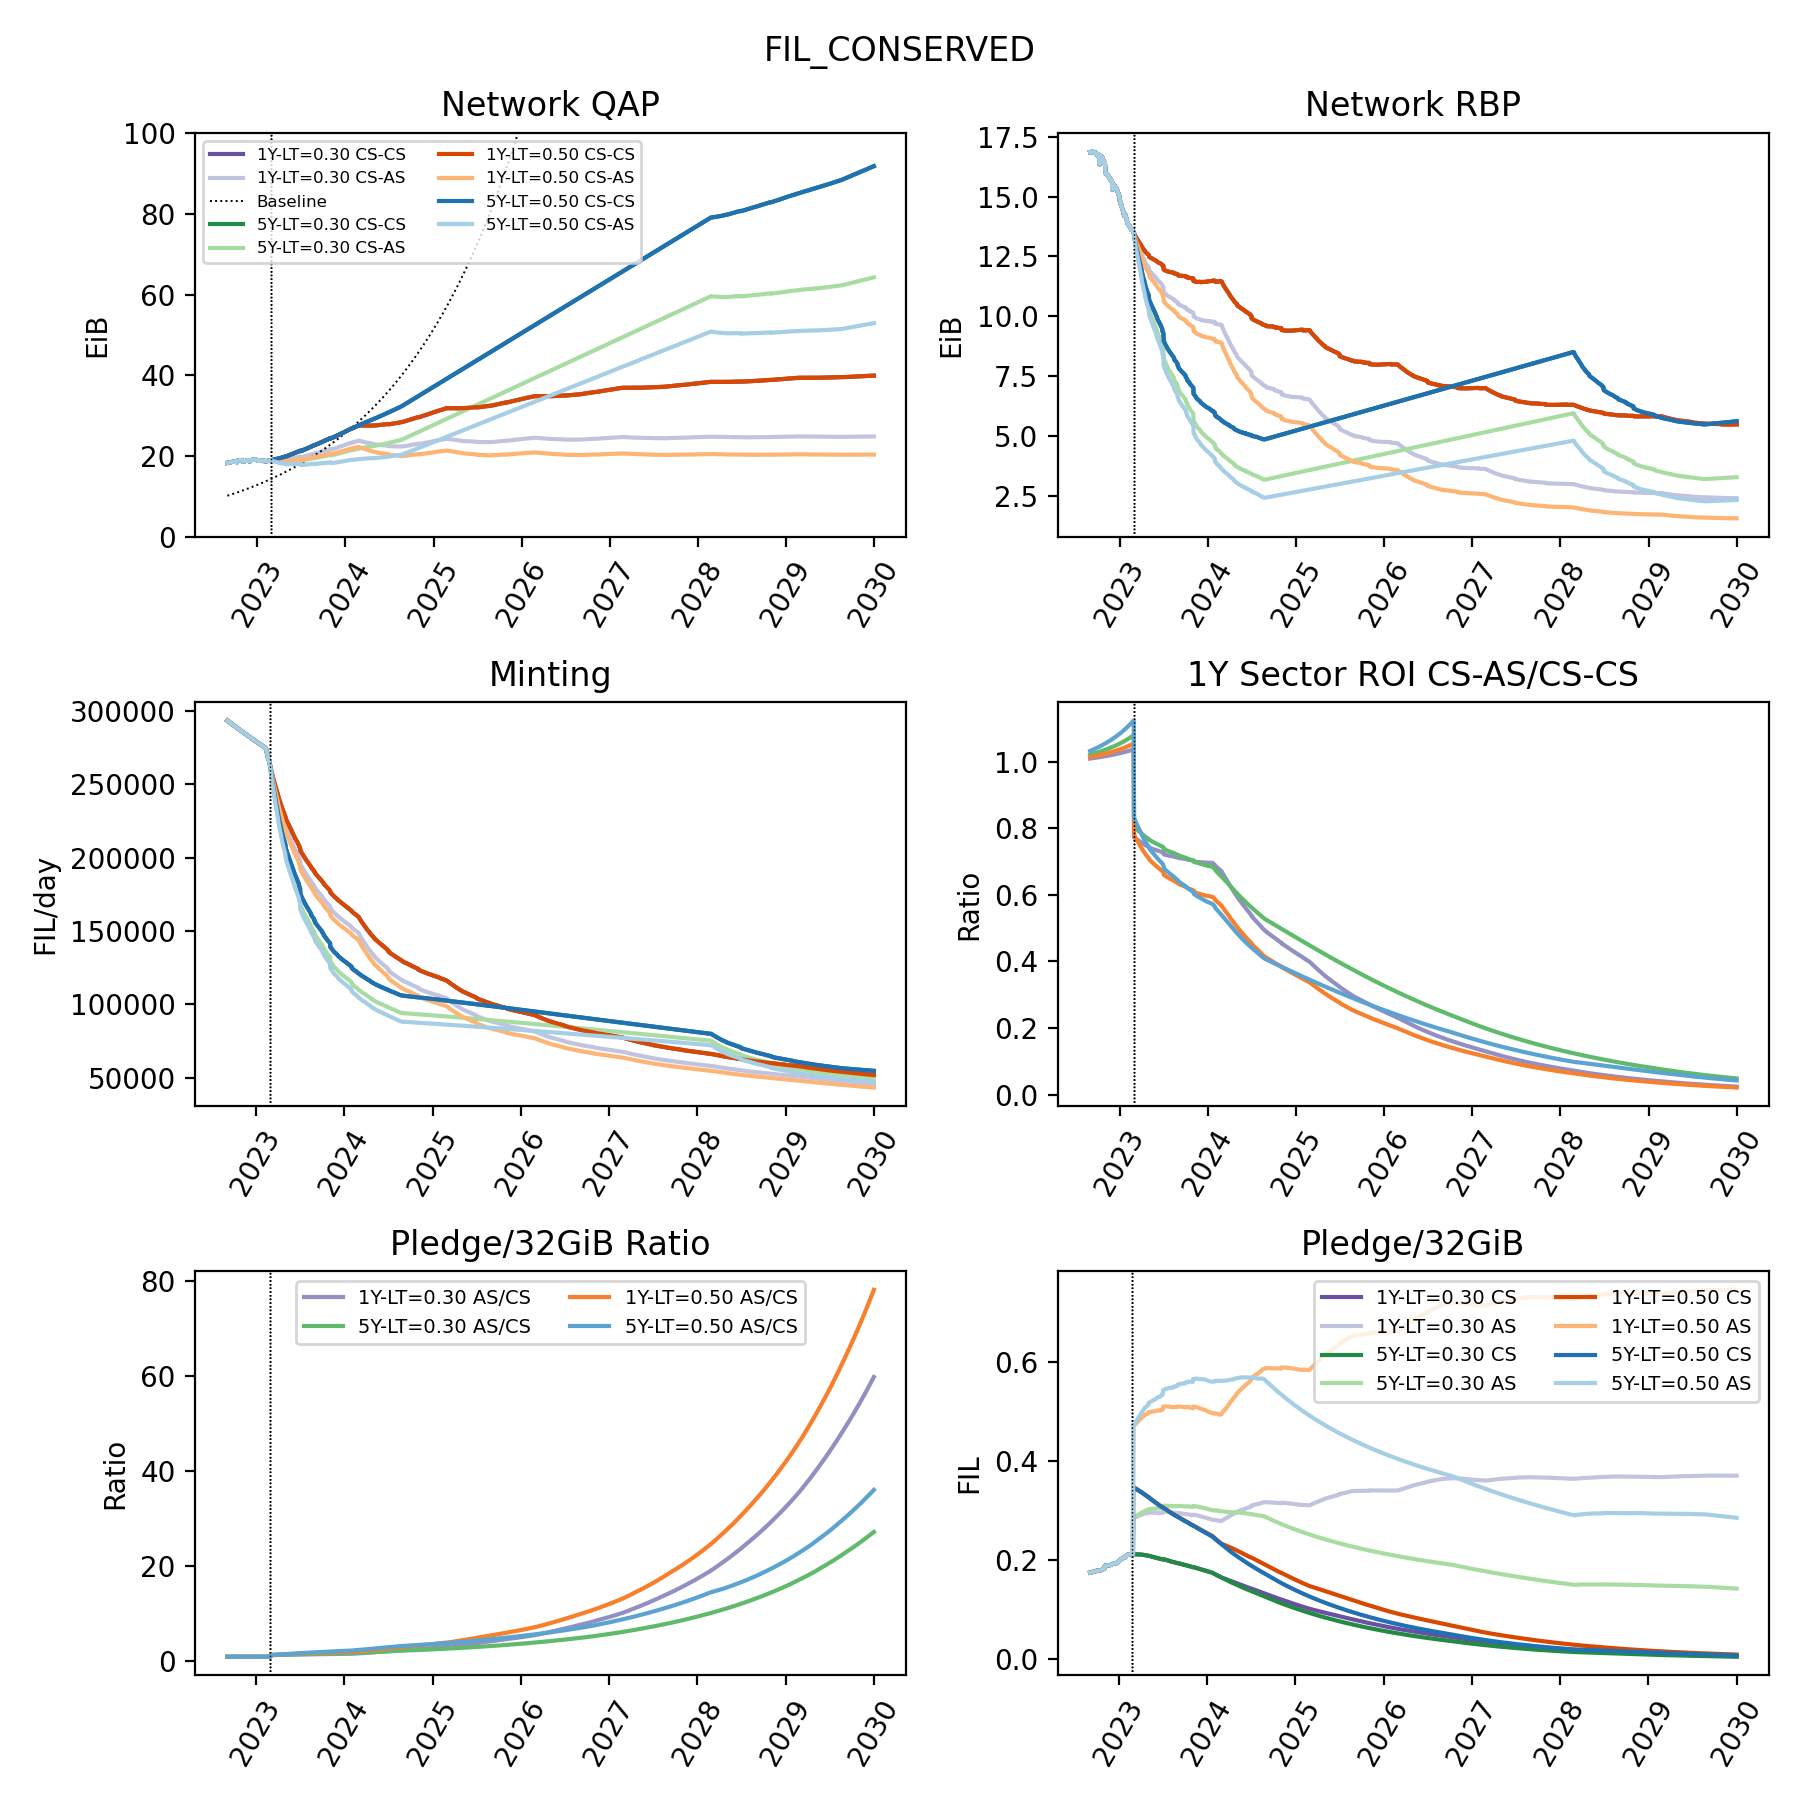

In [27]:
plt_power(duration_loop_results_with_pledge_rescale,
          plt_configs,
          plt_kwargs_list,
          sup_title_str='%s' % (plt_regime.upper(), ),
          save_fp=os.path.join(results_folder, 'power-%s-%s.png' % (plt_regime, plt_durations_vec_yrs_str)) )

<IPython.core.display.Javascript object>


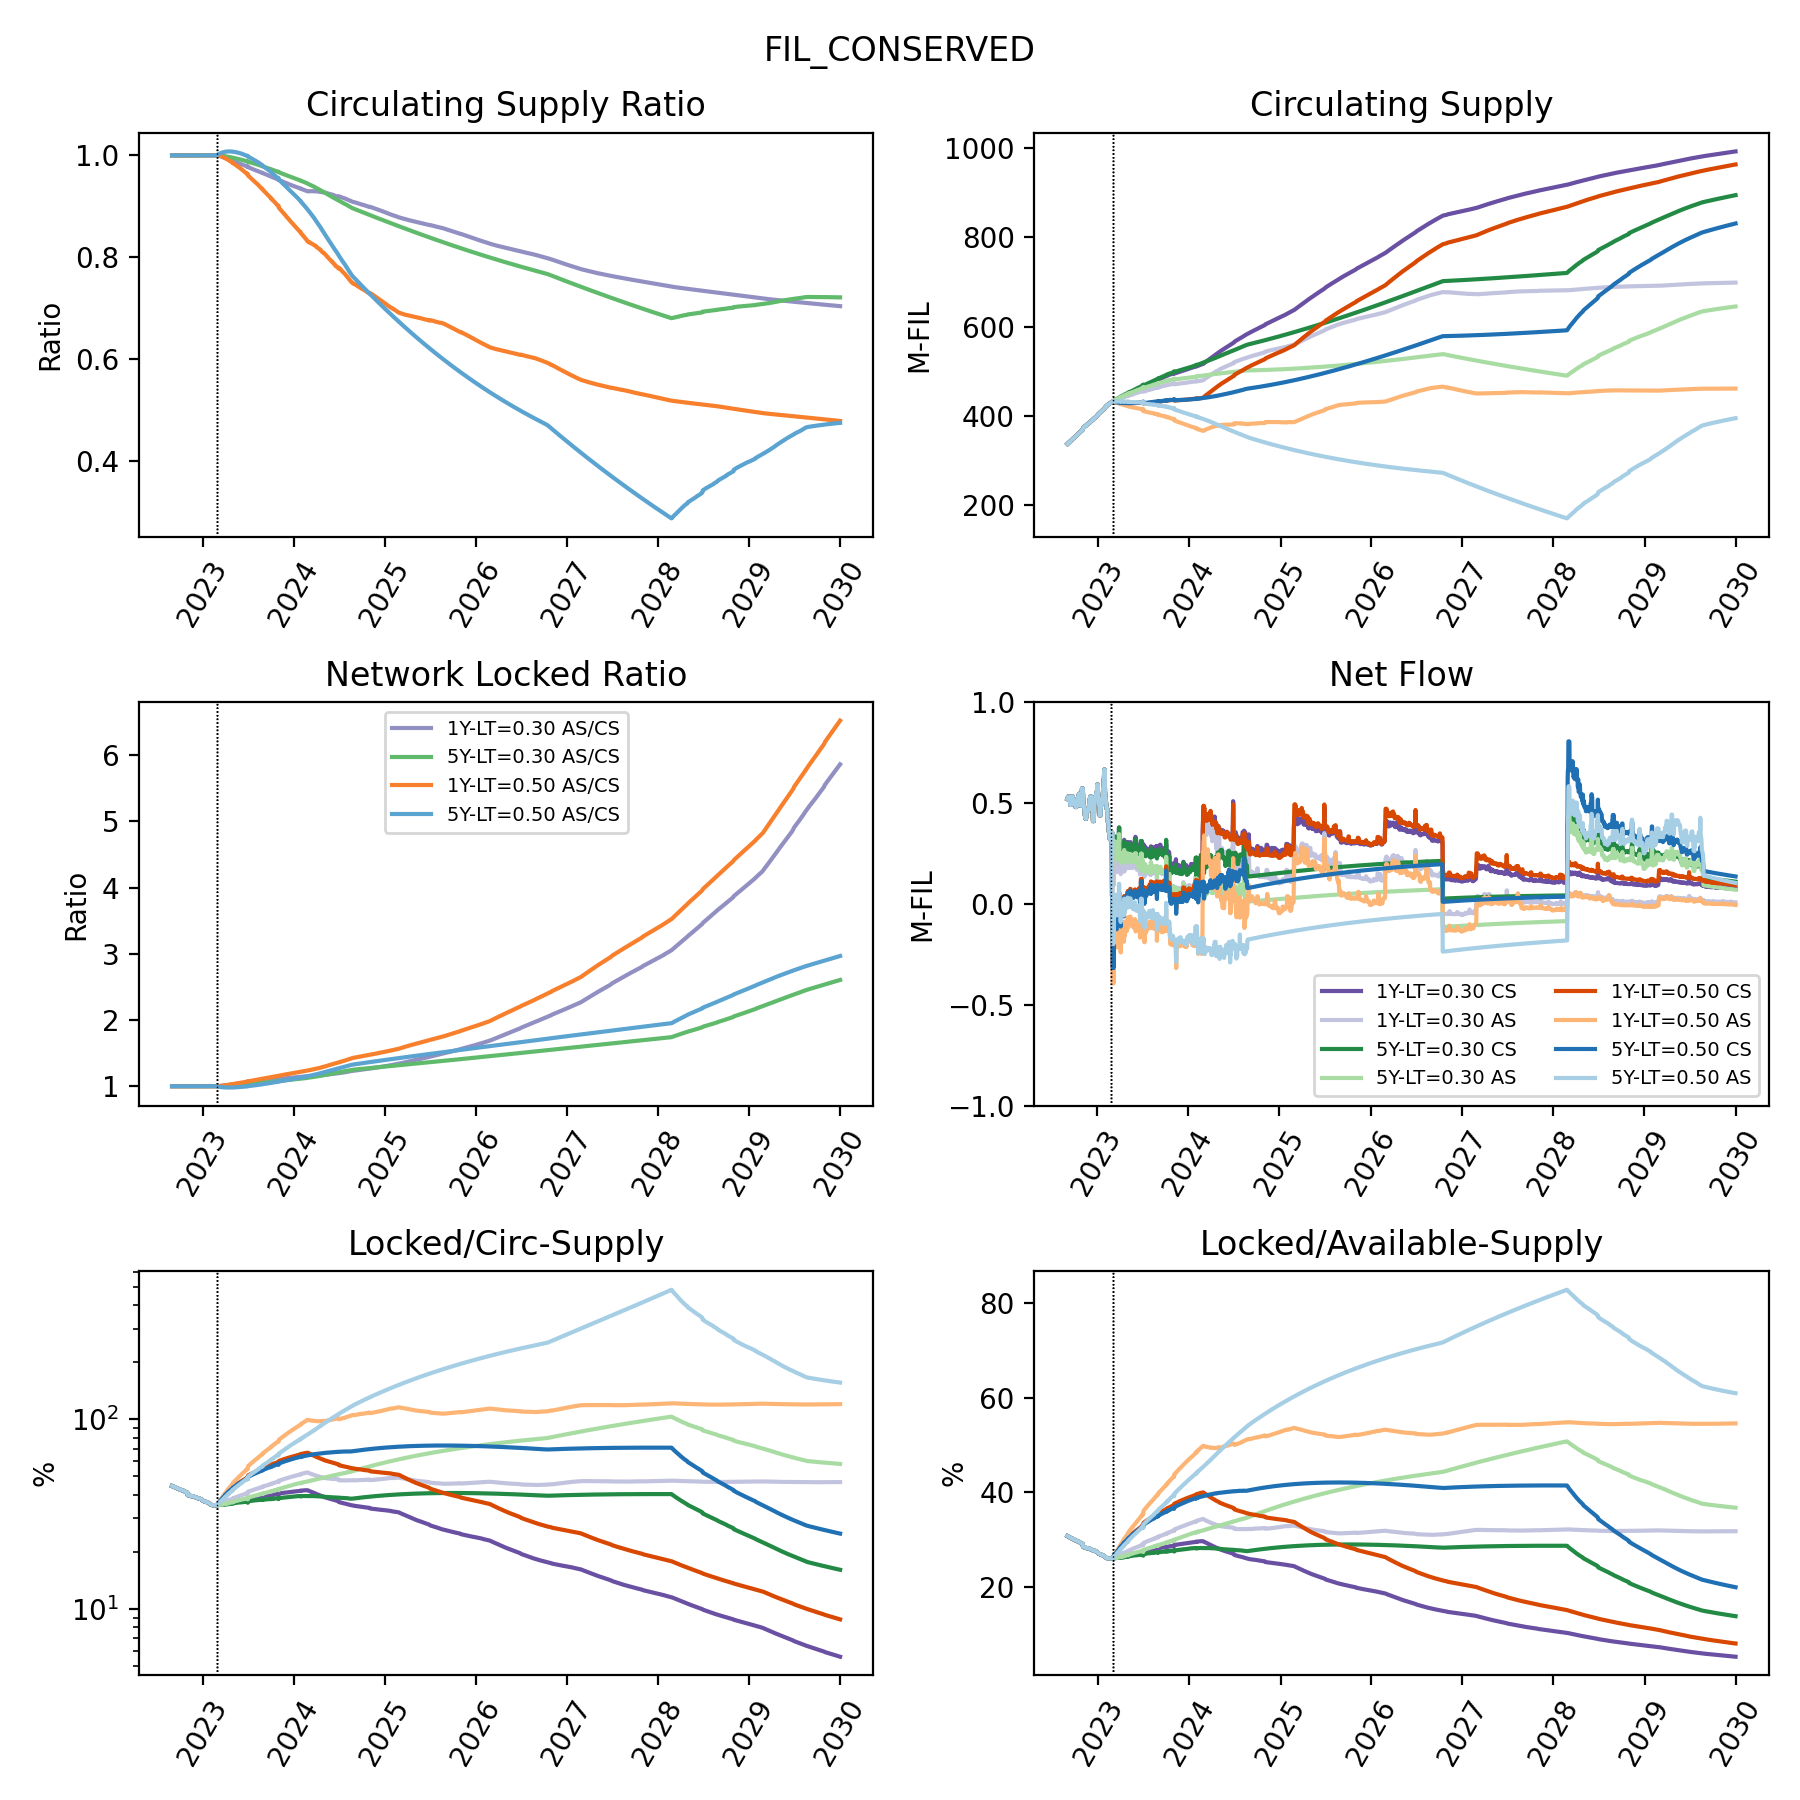

In [28]:
plt_supply(duration_loop_results_with_pledge_rescale,
          plt_configs,
          plt_kwargs_list,
          sup_title_str='%s' % (plt_regime.upper(), ),
          save_fp=os.path.join(results_folder, 'supply-%s-%s.png' % (plt_regime,  plt_durations_vec_yrs_str,)))